In [3]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [4]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu
import colorcet

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [5]:
from suite3d import nbtools as nbui

In [6]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-06',
    'expnum' :         [1,2,3,4,5,6]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21])[:20],
    # number of files to use for the initial pass
    'n_init_files' :   3,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 7,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : False,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6 already exists
Loading job directory for SS003_2024-08-06_1-2-3-4-5-6 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [7]:
job.params['voxel_size_um'] = (20, 2.5, 2.5)

In [8]:
plane_timings_s2p = {
    'init' : 11.7,
    'register' : 33.7-11.7,
    'detect' : 15.51,
    'extract' : 7.41,
}
plane_time_s2p = 59.9 * 192 / 9

time_s2p = plane_time_s2p * 20

timings_s3d = {
    'init' : 5*60 + 2,
    'register' : 73 * 60,
    'detect' : 87 * 60,
    'segment' : 143 * 60,
    'extract' : 0,
}
time_s3d = n.sum(timings_s3d[k] for k in timings_s3d.keys())

/tmp/ipykernel_1152450/2736332395.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  time_s3d = n.sum(timings_s3d[k] for k in timings_s3d.keys())


In [9]:
# %%time
# job.run_init_pass()
# 5 min 2 sec

In [10]:
img3d = job.load_summary()['ref_img_3d']

In [11]:
# %%time
# job.register()
# # 1h 13 min

In [1]:
suite2p_time_per_minute = 25557/76
suite3d_time_per_minute = 22124/76
c

In [2]:
print(suite2p_time_per_minute)
print(suite3d_time_per_minute)

336.2763157894737
291.10526315789474


In [12]:
mov = job.get_registered_movie()

In [13]:
reg = job.load_registration_results()

In [14]:
from suite3d import extension as ext

In [15]:
job.dirs['registered_fused_data']

'/mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6/registered_fused_data'

In [16]:
import time

In [17]:
timing = {'extraction': None, 'segmentation': None, 'corrmap' : 88*60 + 38, 'initialization' : 302, 'mcorr' : 73*60 }

In [23]:
# %%time
# # 1h28
# tic = time.time()
# job.params['voxel_size_um'] = (20, 2.5, 2.5)
# job.params['npil_filt_type'] = 'unif'
# job.params['npil_filt_xy_um'] = 200

# job.params['cell_filt_type'] = 'gaussian'
# job.params['cell_filt_xy_um'] = 5
# job.params['sdnorm_exp'] = 0.85
# job.params['intensity_thresh'] = 0.1 # original run with 0.1
# job.params['standard_vmap'] = True
# job.params['t_batch_size'] = 1000
# job.params['n_proc_corr'] = 64
# job.params['n_proc'] = 32
# job.params['detection_timebin'] = 6
# corr_map_binned = job.calculate_corr_map(output_dir_name='detect-binned')
# # 80 sec + 15 sec (save) per iter ????? without binning?
# # 2min per iter with 5bin
# # 1min 13 sec for 2 iter with 32proc
# toc = time.time()
# # neuropil & cell filters: some multiprocessing, but single-core at the reduction step

In [29]:
detect_time = toc - tic
# 18m34

In [30]:
dtime = detect_time

In [31]:
dtime

1114.5149857997894

In [14]:
from suite3d import extension as ext

In [15]:
corr_map = job.load_corr_map_results('detect-binned')['vmap']
corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

In [31]:
from pathlib import Path

In [32]:
fig_dir = Path('/mnt/md0/s3d-figures')
figname = 'intro'
fdir = fig_dir / figname
plt.rcParams['svg.fonttype'] = 'none'
os.makedirs(fdir, exist_ok=True)

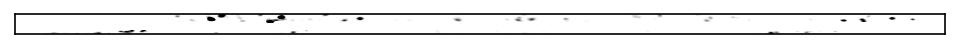

In [72]:
tfu.show_tif(corr_map_thresh[:,:,-30], cmap='Greys', vminmax=(0.02,0.25))
plt.savefig(fdir / 'zsection.svg', dpi=200, bbox_inches=0, pad_inches='tight')

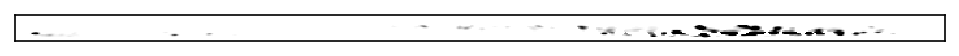

In [75]:
tfu.show_tif(corr_map_thresh[:,-20], cmap='Greys', vminmax=(0.02,0.25))
plt.savefig(fdir / 'zsection2.svg', dpi=200, bbox_inches=0, pad_inches='tight')

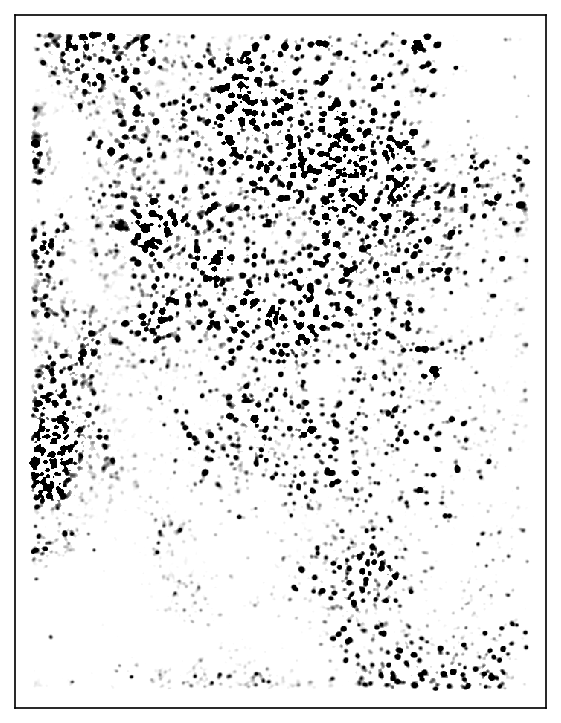

In [35]:
tfu.show_tif(corr_map_thresh[6], cmap='Greys', vminmax=(0.02,0.25))

plt.savefig(fdir / 'xysection.svg', dpi=200, bbox_inches=0, pad_inches='tight')

In [38]:
movx=job.get_registered_movie()

In [41]:
mov = movx[:,:30].compute()

In [44]:
summary = job.load_summary()

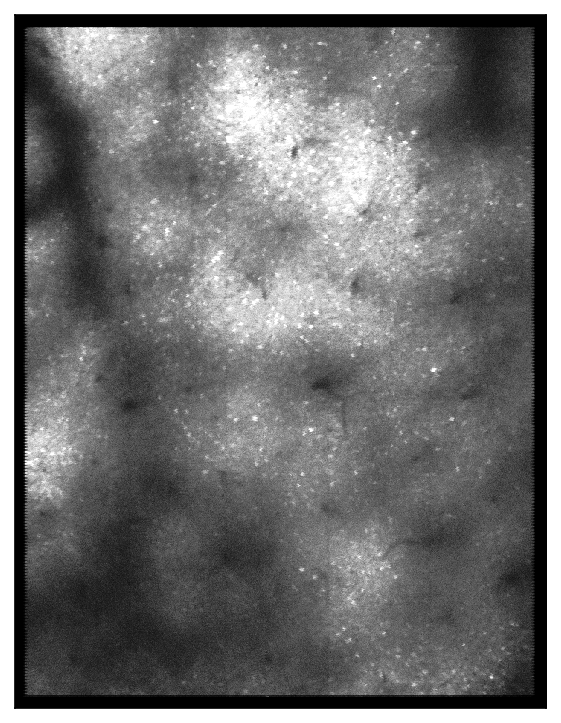

In [47]:
tfu.show_tif(summary['ref_img_3d'][6])
plt.savefig(fdir / 'img-xysection.svg', dpi=200, bbox_inches=0, pad_inches='tight')

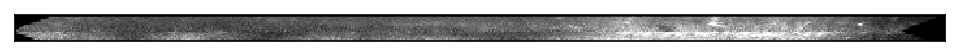

In [71]:
tfu.show_tif(summary['ref_img_3d'][:,-30] / n.percentile(summary['ref_img_3d'][:,500], 30,axis=(1), keepdims=True))
plt.savefig(fdir / 'img-zsection2.svg', dpi=200, bbox_inches=0, pad_inches='tight')

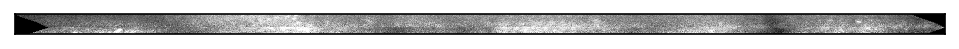

In [68]:
tfu.show_tif(summary['ref_img_3d'][:,:,-50] / n.percentile(summary['ref_img_3d'][:,500], 30,axis=(1), keepdims=True))
plt.savefig(fdir / 'img-zsection.svg', dpi=200, bbox_inches=0, pad_inches='tight')

In [45]:
30*60 + 14

1814

In [24]:
# %%time
# # 30min14sec
# tic = time.time()
# job.params['peak_thresh'] = 0.02

# # when extending an ROI, compare its activity to its neighboring pixels
# # in frames where the fluorescence is above this percentile
# job.params['percentile'] = 99.0

# job.params['extend_thresh'] = 0.05
# job.params['activity_thresh'] = 5.0
# job.params['max_iter'] = 1000
# job.params['ext_subtract_iters'] = 3
# job.params['n_proc_detect'] = 64
# job.params['patch_size_xy'] = (250, 250)
# # 4min46 for 5bin and 4 patches
# # corr_map = job.load_corr_map_results()['vmap']
# job.segment_rois(vmap=corr_map_thresh,input_dir_name='detect-binned', output_dir_name='rois-binned')
# toc = time.time()

In [63]:
%%time
# 1m48
tic = time.time()
job.compute_npil_masks(stats_dir = job.dirs['rois-binned-rois'])
toc = time.time()
npil_time = toc - tic

CPU times: user 1min 14s, sys: 21.7 s, total: 1min 36s
Wall time: 2min 21s


In [55]:
# %%time
# 2172sec
# job.params['npil_to_roi_npix_ratio'] = 2
# job.params['min_npil_npix'] = 100
# tic = time.time()
# traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois-binned-rois'])
# toc = time.time()
# # ext_time = toc - tic

In [62]:
ss = n.load('/mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6/rois-binned/rois/stats_small.npy',allow_pickle=True)

In [64]:
job.export_results('/mnt/md0/runs/pub-figs/outputs/s3d',result_dir_name='rois-binned-rois', )
                   # additional_info = job.load_corr_map_results())

   Created dir /mnt/md0/runs/pub-figs/outputs/s3d/s3d-results-SS003_2024-08-06_1-2-3-4-5-6 to export results
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6/rois-binned/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6/rois-binned/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6/rois-binned/rois/F.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6/rois-binned/rois/spks.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6/rois-binned/rois/Fneu.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6/rois-binned/rois/iscell.npy
      Overwriting existing /mnt/md0/runs/pub-figs/outputs/s3d/s3d-results-SS003_2024-08-06_1-2-3-4-5-6/s3d-params.npy
      Overwriting existing /mnt/md0/runs/pub-figs/outputs/s3d/s3d-results-SS003_2024-08-06_1-2-3-4-5-6/frames.npy
      Overwriting existing /mnt/md0/runs/pub-figs/outputs/s3d/s3d-results-SS003_2024-08-06_1-2-3-4-5-

In [28]:
traces = job.get_traces(patch_dir = job.dirs['rois'])

In [29]:
traces['F'].shape

(5668, 18845)

In [ ]:
snrs = calculate_noise_levels(traces['F'], job.params['fs'])

In [ ]:
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')

In [143]:
save_path = Path('/mnt/md0/runs/s2p-SS003_2024-08-06_2')

In [142]:
os.listdir(save_path)

['F.npy', 'spks.npy', 'suite2p', 'raw']

In [144]:
F_s2p = n.load(save_path / 'F.npy')
spks_s2p = n.load(save_path / 'spks.npy')

In [145]:
spks_s2p.shape

(1733, 2168)